In [1]:
pip install numpy==1.26.4


Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install opencv-python==4.9.0.80


Note: you may need to restart the kernel to use updated packages.


Total Images: 47
Total Masks : 47
Image: EX1.jpg | Mask: EX_GT1.png
Image: EX10.jpg | Mask: EX_GT10.png
Image: EX11.jpg | Mask: EX_GT11.png
Image: EX12.jpg | Mask: EX_GT12.png
Image: EX13.jpg | Mask: EX_GT13.png

Unique Image Sizes: {(960, 1440), (1000, 1504), (1360, 2048), (1696, 2544)}

Average Lesion Pixels per Image: 6800.553191489362
Min Lesion Pixels: 93
Max Lesion Pixels: 41084


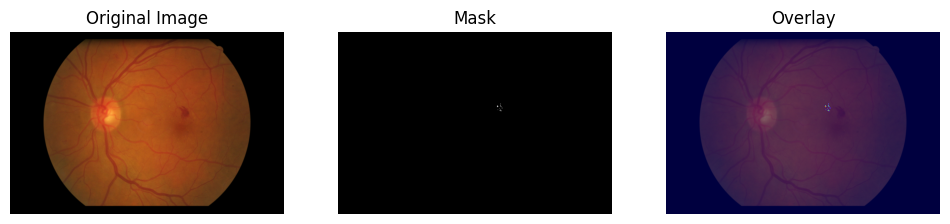

In [3]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from glob import glob

# ===============================
# 1️⃣ Set Base Directory
# ===============================
BASE_DIR = "archive"   # Change if needed

IMAGE_DIR = os.path.join(BASE_DIR, "EX")
MASK_DIR  = os.path.join(BASE_DIR, "Annotation_EX")

# ===============================
# 2️⃣ Load Image & Mask Paths
# ===============================
image_paths = sorted(glob(os.path.join(IMAGE_DIR, "*.jpg")))
mask_paths  = sorted(glob(os.path.join(MASK_DIR, "*.png")))

print("Total Images:", len(image_paths))
print("Total Masks :", len(mask_paths))

# ===============================
# 3️⃣ Check File Matching
# ===============================
for i in range(5):
    print("Image:", os.path.basename(image_paths[i]),
          "| Mask:", os.path.basename(mask_paths[i]))

# ===============================
# 4️⃣ Verify Size & Binary Nature
# ===============================
sizes = []
lesion_pixel_counts = []

for img_path, mask_path in zip(image_paths, mask_paths):
    img = cv2.imread(img_path)
    mask = cv2.imread(mask_path, 0)

    sizes.append(img.shape[:2])
    
    # Count lesion pixels
    lesion_pixel_counts.append(np.sum(mask > 0))

unique_sizes = set(sizes)
print("\nUnique Image Sizes:", unique_sizes)

print("\nAverage Lesion Pixels per Image:",
      np.mean(lesion_pixel_counts))

print("Min Lesion Pixels:",
      np.min(lesion_pixel_counts))

print("Max Lesion Pixels:",
      np.max(lesion_pixel_counts))

# ===============================
# 5️⃣ Visual Sanity Check
# ===============================
sample_index = 3  # change to view different images

img = cv2.imread(image_paths[sample_index])
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

mask = cv2.imread(mask_paths[sample_index], 0)

plt.figure(figsize=(12,5))

plt.subplot(1,3,1)
plt.title("Original Image")
plt.imshow(img)
plt.axis("off")

plt.subplot(1,3,2)
plt.title("Mask")
plt.imshow(mask, cmap="gray")
plt.axis("off")

plt.subplot(1,3,3)
plt.title("Overlay")
plt.imshow(img)
plt.imshow(mask, cmap="jet", alpha=0.5)
plt.axis("off")

plt.show()


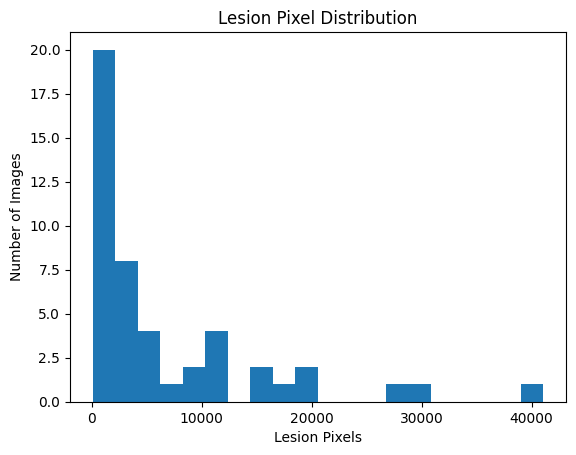

In [4]:
import matplotlib.pyplot as plt

plt.hist(lesion_pixel_counts, bins=20)
plt.title("Lesion Pixel Distribution")
plt.xlabel("Lesion Pixels")
plt.ylabel("Number of Images")
plt.show()


In [5]:
import os
import cv2
import numpy as np
from glob import glob

# ===============================
# 1️⃣ Load Paths
# ===============================
BASE_DIR = "archive"

IMAGE_DIR = os.path.join(BASE_DIR, "EX")
MASK_DIR  = os.path.join(BASE_DIR, "Annotation_EX")

image_paths = sorted(glob(os.path.join(IMAGE_DIR, "*.jpg")))
mask_paths  = sorted(glob(os.path.join(MASK_DIR, "*.png")))

# ===============================
# 2️⃣ Preprocessing Function
# ===============================
def preprocess_image(img_path):
    img = cv2.imread(img_path)
    
    # Extract green channel
    green = img[:, :, 1]
    
    # Normalize to [0,1]
    green = green.astype(np.float32) / 255.0
    
    return green


def preprocess_mask(mask_path):
    mask = cv2.imread(mask_path, 0)
    
    # Binarize
    mask = (mask > 0).astype(np.float32)
    
    return mask


# ===============================
# 3️⃣ Process All Images
# ===============================
images = []
masks  = []

for img_path, mask_path in zip(image_paths, mask_paths):
    img  = preprocess_image(img_path)
    mask = preprocess_mask(mask_path)
    
    images.append(img)
    masks.append(mask)

images = np.array(images, dtype=object)
masks  = np.array(masks, dtype=object)

print("Total preprocessed images:", len(images))
print("Sample image shape:", images[0].shape)
print("Sample mask shape:", masks[0].shape)

print("Image pixel range:", images[0].min(), images[0].max())
print("Mask unique values:", np.unique(masks[0]))


Total preprocessed images: 47
Sample image shape: (1696, 2544)
Sample mask shape: (1696, 2544)
Image pixel range: 0.0 0.8745098
Mask unique values: [0. 1.]


In [6]:
import random

PATCH_SIZE = 192
POS_PATCHES_PER_IMAGE = 3
NEG_PATCHES_PER_IMAGE = 2

patch_images = []
patch_masks  = []

def extract_patch(img, mask, center_x, center_y):
    h, w = img.shape
    
    half = PATCH_SIZE // 2
    
    x1 = max(center_x - half, 0)
    y1 = max(center_y - half, 0)
    
    x2 = min(x1 + PATCH_SIZE, w)
    y2 = min(y1 + PATCH_SIZE, h)
    
    # Adjust if near border
    if x2 - x1 < PATCH_SIZE:
        x1 = x2 - PATCH_SIZE
    if y2 - y1 < PATCH_SIZE:
        y1 = y2 - PATCH_SIZE
    
    patch_img = img[y1:y2, x1:x2]
    patch_mask = mask[y1:y2, x1:x2]
    
    return patch_img, patch_mask


for img, mask in zip(images, masks):
    
    h, w = img.shape
    
    # =====================
    # Positive Patches
    # =====================
    lesion_pixels = np.argwhere(mask == 1)
    
    if len(lesion_pixels) > 0:
        for _ in range(POS_PATCHES_PER_IMAGE):
            y, x = random.choice(lesion_pixels)
            p_img, p_mask = extract_patch(img, mask, x, y)
            patch_images.append(p_img)
            patch_masks.append(p_mask)
    
    # =====================
    # Negative Patches
    # =====================
    for _ in range(NEG_PATCHES_PER_IMAGE):
        while True:
            x = random.randint(0, w-1)
            y = random.randint(0, h-1)
            
            p_img, p_mask = extract_patch(img, mask, x, y)
            
            if np.sum(p_mask) == 0:
                patch_images.append(p_img)
                patch_masks.append(p_mask)
                break


patch_images = np.array(patch_images)
patch_masks  = np.array(patch_masks)

print("Total patches:", len(patch_images))
print("Patch shape:", patch_images[0].shape)
print("Mask unique:", np.unique(patch_masks[0]))


Total patches: 235
Patch shape: (192, 192)
Mask unique: [0. 1.]


In [7]:
total_lesion_pixels = np.sum(patch_masks)
total_pixels = patch_masks.size

print("Lesion ratio in patches:",
      total_lesion_pixels / total_pixels)


Lesion ratio in patches: 0.025915383052600473


In [8]:
from sklearn.model_selection import train_test_split

# ===============================
# 1️⃣ Add channel dimension
# ===============================
patch_images = patch_images[..., np.newaxis]
patch_masks  = patch_masks[..., np.newaxis]

patch_images = patch_images.astype(np.float32)
patch_masks  = patch_masks.astype(np.float32)

print("New image shape:", patch_images.shape)
print("New mask shape :", patch_masks.shape)

# ===============================
# 2️⃣ Train / Validation Split
# ===============================
X_train, X_val, y_train, y_val = train_test_split(
    patch_images,
    patch_masks,
    test_size=0.2,
    random_state=42,
    shuffle=True
)


print("\nTrain shape:", X_train.shape)
print("Validation shape:", X_val.shape)


New image shape: (235, 192, 192, 1)
New mask shape : (235, 192, 192, 1)

Train shape: (188, 192, 192, 1)
Validation shape: (47, 192, 192, 1)


In [9]:
import tensorflow as tf
from tensorflow.keras import layers, models, backend as K

# ===============================
# Dice Loss
# ===============================
def dice_loss(y_true, y_pred):
    smooth = 1e-6
    
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    
    intersection = K.sum(y_true_f * y_pred_f)
    
    return 1 - (2. * intersection + smooth) / (
        K.sum(y_true_f) + K.sum(y_pred_f) + smooth
    )

def bce_dice_loss(y_true, y_pred):
    bce = tf.keras.losses.binary_crossentropy(y_true, y_pred)
    dloss = dice_loss(y_true, y_pred)
    return bce + dloss


# ===============================
# Conv Block
# ===============================
def conv_block(x, filters, dropout=0.0):
    x = layers.Conv2D(filters, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.Conv2D(filters, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    if dropout > 0:
        x = layers.Dropout(dropout)(x)

    return x


# ===============================
# Build U-Net
# ===============================
def build_unet(input_shape=(256,256,1)):
    inputs = layers.Input(input_shape)

    # Encoder
    c1 = conv_block(inputs, 32)
    p1 = layers.MaxPooling2D()(c1)

    c2 = conv_block(p1, 64)
    p2 = layers.MaxPooling2D()(c2)

    c3 = conv_block(p2, 128)
    p3 = layers.MaxPooling2D()(c3)

    c4 = conv_block(p3, 256, dropout=0.3)
    p4 = layers.MaxPooling2D()(c4)

    # Bottleneck
    bn = conv_block(p4, 512, dropout=0.3)

    # Decoder
    u1 = layers.Conv2DTranspose(256, 2, strides=2, padding="same")(bn)
    u1 = layers.concatenate([u1, c4])
    c5 = conv_block(u1, 256)

    u2 = layers.Conv2DTranspose(128, 2, strides=2, padding="same")(c5)
    u2 = layers.concatenate([u2, c3])
    c6 = conv_block(u2, 128)

    u3 = layers.Conv2DTranspose(64, 2, strides=2, padding="same")(c6)
    u3 = layers.concatenate([u3, c2])
    c7 = conv_block(u3, 64)

    u4 = layers.Conv2DTranspose(32, 2, strides=2, padding="same")(c7)
    u4 = layers.concatenate([u4, c1])
    c8 = conv_block(u4, 32)

    outputs = layers.Conv2D(1, 1, activation="sigmoid")(c8)

    model = models.Model(inputs, outputs)
    return model



In [10]:
def build_unet_small(input_shape=(192,192,1)):
    inputs = layers.Input(input_shape)

    # Encoder
    c1 = conv_block(inputs, 16)
    p1 = layers.MaxPooling2D()(c1)

    c2 = conv_block(p1, 32)
    p2 = layers.MaxPooling2D()(c2)

    c3 = conv_block(p2, 64)
    p3 = layers.MaxPooling2D()(c3)

    c4 = conv_block(p3, 128, dropout=0.3)
    p4 = layers.MaxPooling2D()(c4)

    # Bottleneck
    bn = conv_block(p4, 256, dropout=0.3)

    # Decoder
    u1 = layers.Conv2DTranspose(128, 2, strides=2, padding="same")(bn)
    u1 = layers.concatenate([u1, c4])
    c5 = conv_block(u1, 128)

    u2 = layers.Conv2DTranspose(64, 2, strides=2, padding="same")(c5)
    u2 = layers.concatenate([u2, c3])
    c6 = conv_block(u2, 64)

    u3 = layers.Conv2DTranspose(32, 2, strides=2, padding="same")(c6)
    u3 = layers.concatenate([u3, c2])
    c7 = conv_block(u3, 32)

    u4 = layers.Conv2DTranspose(16, 2, strides=2, padding="same")(c7)
    u4 = layers.concatenate([u4, c1])
    c8 = conv_block(u4, 16)

    outputs = layers.Conv2D(1, 1, activation="sigmoid")(c8)

    return models.Model(inputs, outputs)


model = build_unet_small()

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss=bce_dice_loss,
    metrics=["accuracy"]
)

model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)      │ (None, 192, 192, 1)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d (Conv2D)               │ (None, 192, 192, 16)      │             160 │ input_layer[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization           │ (None, 192, 192, 16)      │              64 │ conv2d[0][0]               │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation (Activation)       │ (None, 192, 192, 16)      │               0 │ batch_normalization[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_1 (Conv2D)             │ (None, 192, 192, 16)      │           2,320 │ activation[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_1         │ (None, 192, 192, 16)      │              64 │ conv2d_1[0][0]             │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation_1 (Activation)     │ (None, 192, 192, 16)      │               0 │ batch_normalization_1[0][… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d (MaxPooling2D)  │ (None, 96, 96, 16)        │               0 │ activation_1[0][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_2 (Conv2D)             │ (None, 96, 96, 32)        │           4,640 │ max_pooling2d[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_2         │ (None, 96, 96, 32)        │             128 │ conv2d_2[0][0]             │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation_2 (Activation)     │ (None, 96, 96, 32)        │               0 │ batch_normalization_2[0][… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_3 (Conv2D)             │ (None, 96, 96, 32)        │           9,248 │ activation_2[0][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_3         │ (None, 96, 96, 32)        │             128 │ conv2d_3[0][0]             │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation_3 (Activation)     │ (None, 96, 96, 32)        │               0 │ batch_normalization_3[0][… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d_1               │ (None, 48, 48, 32)        │               0 │ activation_3[0][0]         │
│ (MaxPooling2D)                │                           │               

 Total params: 1,946,705 (7.43 MB)

 Trainable params: 1,943,761 (7.41 MB)

 Non-trainable params: 2,944 (11.50 KB)

In [11]:
def dice_coef(y_true, y_pred):
    smooth = 1e-6
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (
        K.sum(y_true_f) + K.sum(y_pred_f) + smooth
    )

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss=bce_dice_loss,
    metrics=[dice_coef]
)


In [13]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=8,              # stop if no improvement for 8 epochs
        restore_best_weights=True
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,              # reduce LR by half
        patience=4,
        min_lr=1e-6,
        verbose=1
    )
]


In [14]:
history = model.fit(
    X_train,
    y_train,
    validation_data=(X_val, y_val),
    epochs=60,
    batch_size=2,
    callbacks=callbacks
)


Epoch 1/60
94/94 ━━━━━━━━━━━━━━━━━━━━ 48s 281ms/step - dice_coef: 0.0674 - loss: 1.8531 - val_dice_coef: 0.0410 - val_loss: 1.7043 - learning_rate: 1.0000e-04
Epoch 2/60
94/94 ━━━━━━━━━━━━━━━━━━━━ 23s 249ms/step - dice_coef: 0.0597 - loss: 1.5535 - val_dice_coef: 0.0416 - val_loss: 1.5832 - learning_rate: 1.0000e-04
Epoch 3/60
94/94 ━━━━━━━━━━━━━━━━━━━━ 23s 243ms/step - dice_coef: 0.0667 - loss: 1.4399 - val_dice_coef: 0.0424 - val_loss: 1.4774 - learning_rate: 1.0000e-04
Epoch 4/60
94/94 ━━━━━━━━━━━━━━━━━━━━ 25s 264ms/step - dice_coef: 0.0692 - loss: 1.3908 - val_dice_coef: 0.0442 - val_loss: 1.4046 - learning_rate: 1.0000e-04
Epoch 5/60
94/94 ━━━━━━━━━━━━━━━━━━━━ 26s 276ms/step - dice_coef: 0.0720 - loss: 1.3573 - val_dice_coef: 0.0485 - val_loss: 1.3769 - learning_rate: 1.0000e-04
Epoch 6/60
94/94 ━━━━━━━━━━━━━━━━━━━━ 30s 316ms/step - dice_coef: 0.0706 - loss: 1.3373 - val_dice_coef: 0.0483 - val_loss: 1.3425 - learning_rate: 1.0000e-04
Epoch 7/60
94/94 ━━━━━━━━━━━━━━━━━━━━ 39s 416m

In [15]:
preds = model.predict(X_val)
print(preds.shape)
print("Min/Max prediction:", preds.min(), preds.max())


2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step
(47, 192, 192, 1)
Min/Max prediction: 0.007495916 0.9999971


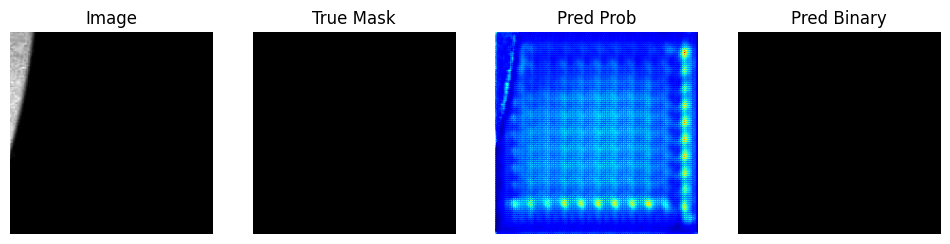

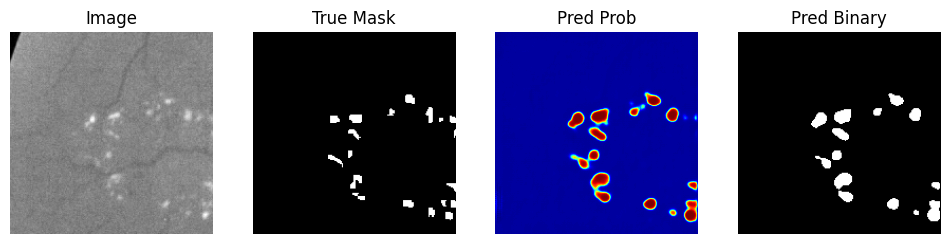

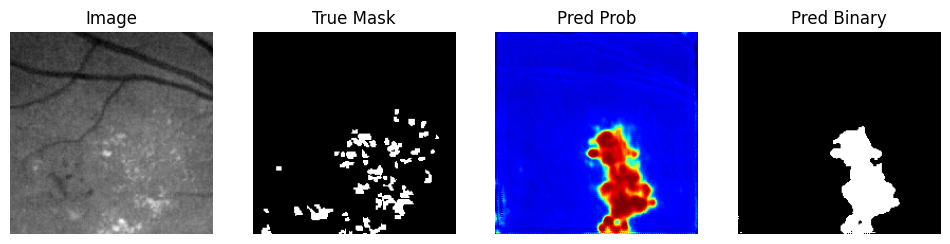

In [16]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_prediction(idx):
    img = X_val[idx].squeeze()
    true_mask = y_val[idx].squeeze()
    pred_mask = preds[idx].squeeze()

    pred_bin = (pred_mask > 0.5).astype(np.uint8)

    plt.figure(figsize=(12,4))

    plt.subplot(1,4,1)
    plt.title("Image")
    plt.imshow(img, cmap='gray')
    plt.axis("off")

    plt.subplot(1,4,2)
    plt.title("True Mask")
    plt.imshow(true_mask, cmap='gray')
    plt.axis("off")

    plt.subplot(1,4,3)
    plt.title("Pred Prob")
    plt.imshow(pred_mask, cmap='jet')
    plt.axis("off")

    plt.subplot(1,4,4)
    plt.title("Pred Binary")
    plt.imshow(pred_bin, cmap='gray')
    plt.axis("off")

    plt.show()


for i in range(3):
    visualize_prediction(i)


In [17]:
def predict_full_image(model, image, patch_size=192, stride=96):
    """
    image: (H, W) normalized
    returns: full predicted mask (H, W)
    """

    H, W = image.shape
    prediction = np.zeros((H, W))
    counter = np.zeros((H, W))

    for y in range(0, H - patch_size + 1, stride):
        for x in range(0, W - patch_size + 1, stride):

            patch = image[y:y+patch_size, x:x+patch_size]
            patch_input = patch[np.newaxis, ..., np.newaxis]

            pred = model.predict(patch_input, verbose=0)[0, ..., 0]

            prediction[y:y+patch_size, x:x+patch_size] += pred
            counter[y:y+patch_size, x:x+patch_size] += 1

    prediction /= (counter + 1e-6)

    return prediction


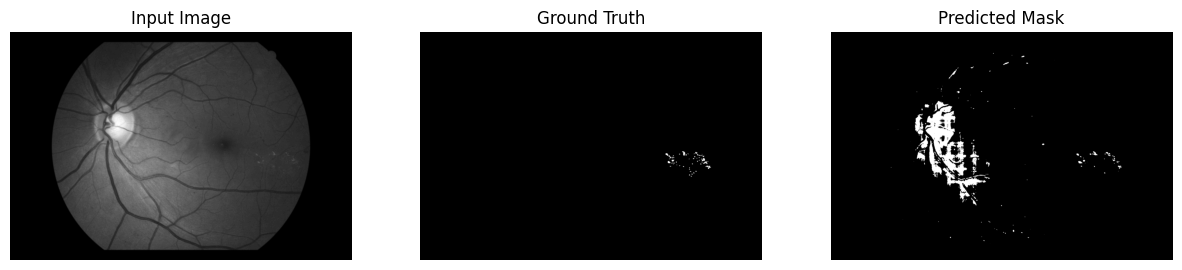

In [18]:
idx = 0

full_img = images[idx]       # original green channel
full_mask = masks[idx]       # ground truth

full_pred = predict_full_image(model, full_img)

binary_pred = (full_pred > 0.5).astype(np.uint8)

plt.figure(figsize=(15,5))

plt.subplot(1,3,1)
plt.title("Input Image")
plt.imshow(full_img, cmap='gray')
plt.axis("off")

plt.subplot(1,3,2)
plt.title("Ground Truth")
plt.imshow(full_mask, cmap='gray')
plt.axis("off")

plt.subplot(1,3,3)
plt.title("Predicted Mask")
plt.imshow(binary_pred, cmap='gray')
plt.axis("off")

plt.show()


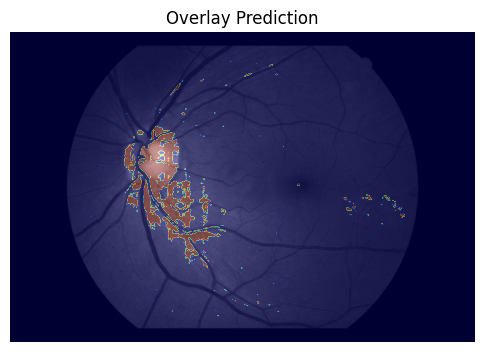

In [19]:
plt.figure(figsize=(6,6))
plt.imshow(full_img, cmap='gray')
plt.imshow(binary_pred, cmap='jet', alpha=0.4)
plt.title("Overlay Prediction")
plt.axis("off")
plt.show()



Showing Image Index: 21


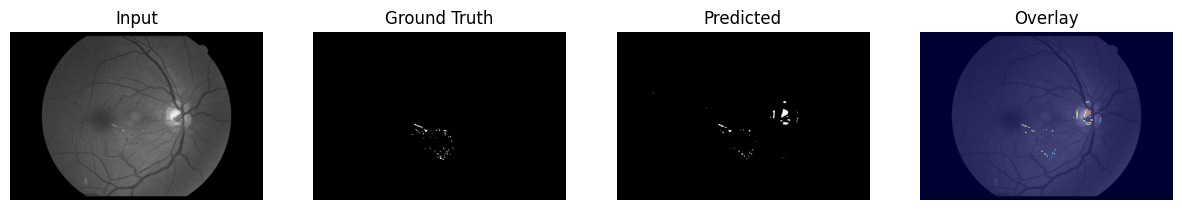


Showing Image Index: 15


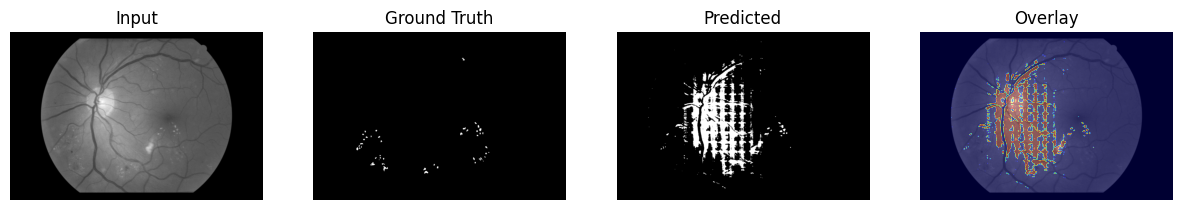


Showing Image Index: 35


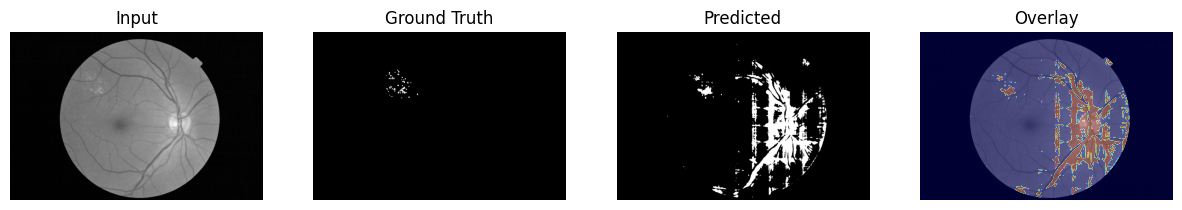

In [20]:
import random
import matplotlib.pyplot as plt
import numpy as np

def evaluate_random_images(model, images, masks, num_images=3):
    indices = random.sample(range(len(images)), num_images)

    for idx in indices:
        print(f"\nShowing Image Index: {idx}")

        full_img = images[idx]
        full_mask = masks[idx]

        full_pred = predict_full_image(model, full_img)
        binary_pred = (full_pred > 0.5).astype(np.uint8)

        plt.figure(figsize=(15,4))

        # Input
        plt.subplot(1,4,1)
        plt.title("Input")
        plt.imshow(full_img, cmap='gray')
        plt.axis("off")

        # Ground truth
        plt.subplot(1,4,2)
        plt.title("Ground Truth")
        plt.imshow(full_mask, cmap='gray')
        plt.axis("off")

        # Prediction
        plt.subplot(1,4,3)
        plt.title("Predicted")
        plt.imshow(binary_pred, cmap='gray')
        plt.axis("off")

        # Overlay
        plt.subplot(1,4,4)
        plt.title("Overlay")
        plt.imshow(full_img, cmap='gray')
        plt.imshow(binary_pred, cmap='jet', alpha=0.4)
        plt.axis("off")

        plt.show()


evaluate_random_images(model, images, masks, num_images=3)



Showing Image Index: 23


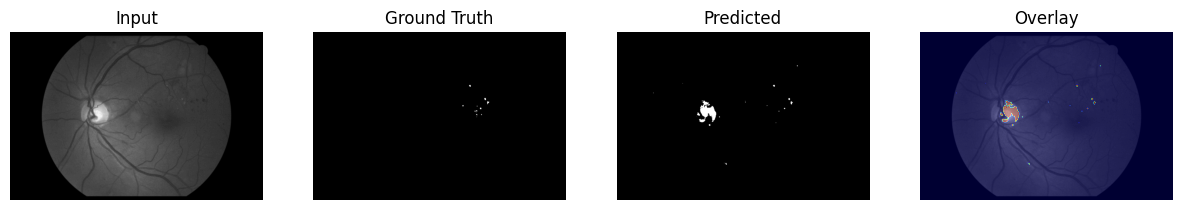


Showing Image Index: 44


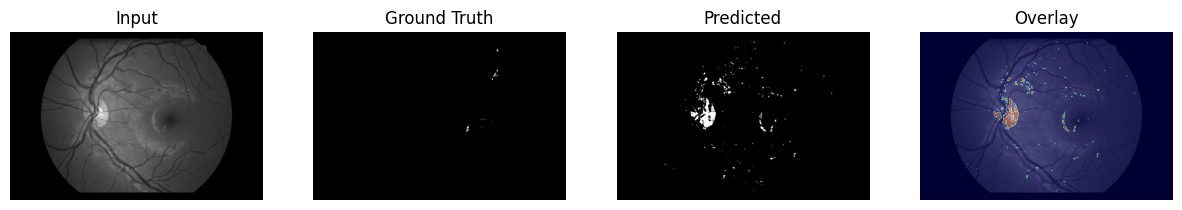


Showing Image Index: 38


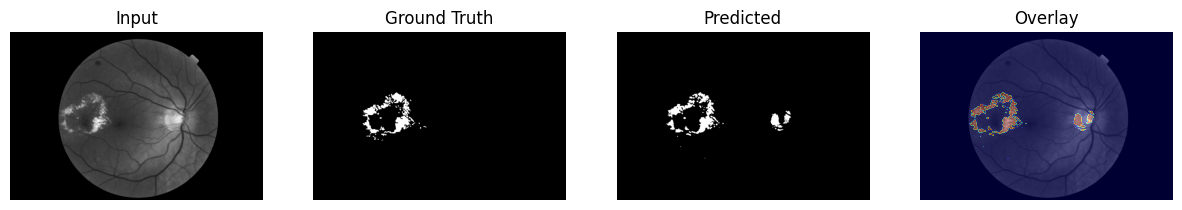

In [21]:
import random
import matplotlib.pyplot as plt
import numpy as np

def evaluate_random_images(model, images, masks, num_images=3):
    indices = random.sample(range(len(images)), num_images)

    for idx in indices:
        print(f"\nShowing Image Index: {idx}")

        full_img = images[idx]
        full_mask = masks[idx]

        full_pred = predict_full_image(model, full_img)
        binary_pred = (full_pred > 0.5).astype(np.uint8)

        plt.figure(figsize=(15,4))

        # Input
        plt.subplot(1,4,1)
        plt.title("Input")
        plt.imshow(full_img, cmap='gray')
        plt.axis("off")

        # Ground truth
        plt.subplot(1,4,2)
        plt.title("Ground Truth")
        plt.imshow(full_mask, cmap='gray')
        plt.axis("off")

        # Prediction
        plt.subplot(1,4,3)
        plt.title("Predicted")
        plt.imshow(binary_pred, cmap='gray')
        plt.axis("off")

        # Overlay
        plt.subplot(1,4,4)
        plt.title("Overlay")
        plt.imshow(full_img, cmap='gray')
        plt.imshow(binary_pred, cmap='jet', alpha=0.4)
        plt.axis("off")

        plt.show()


evaluate_random_images(model, images, masks, num_images=3)
